<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Risk Evaluation for Retail Banks</b><br>
    <br>Feature Engineering - Application Data<br><br> 
</p>

<p style="text-align: right;">Module 4: Machine Learning<br>
Sprint 4: Machine Learning Capstone Project<br>
Author : Renato Mariano</p>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the Capstone Project of of the Machine Learning Module! In this sprint, we embark on an exciting journey to develop a **risk evaluation service for retail banks**, leveraging the power of data science and machine learning.

This work is part of a series of notebooks starting with 01_EDA_application.

In the previous notebook we delved into an Exploration of the Application Data. Here will start our feature engineering on this set!

<h2 style="color:#774CAD">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process
import re

import utils
import EDA
import feat_eng
import pipelines
import model_select

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier


In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

%load_ext blackcellmagic

<h1 style="color:#774CAD">Multicolinear Features and Organization Type</h1>

We will build this notebook up by **applying transformations** to the dataframe and after a couples of transformations we will **run a LightGBM** in the same random state to **evaluate its performance**.

This approach was chosen since I have very limited domain knowledge of loans and influencing factors for loan defaulters. In this context the model will highlight which features have a greater predicting impact.

Let's load our data and separate our features and target.

In [3]:
df_train = utils.load_df(file_path="data/df_train.csv")
col_info = utils.load_df(file_path="data/home-credit-default-risk/HomeCredit_columns_description.csv", encoding='unicode_escape')
df_info = EDA.custom_info(df_train)

X_train = df_train.drop(["TARGET", "SK_ID_CURR"], axis=1)
y_train = df_train["TARGET"]

The shape of the data is: (153755, 122)
load_df took 4.354 seconds

The shape of the data is: (219, 5)
load_df took 0.016 seconds

Shape: (153755, 122)



The first steps to be perfomed will be **dropping naturally multicolinear features**: BASEMENTAREA (_AVG, _MEDI, _MODE). We will **keep in this process only the _MEDI** variant. Some of the features with these suffix only presented the MODE value and were included as exception (will be kept).

As previously shown **YEARS_BEGINEXPLUATATION_MEDI has 0 values that don't flag having a house**. We will **treat them as Null**.

The features starting with **"DAYS_"** presented values growing in the negative scale, maybe to highlight the time passed to the model. Here they will **multiply them by -1**. Besides, for **DAYS_EMPLOYED** we will flag the anomalies and attribute null values.

We will also apply a **map to the Organization type**.

In [4]:
import importlib
importlib.reload(feat_eng)

<module 'feat_eng' from 'c:\\Users\\renat\\TCProjects\\M3_S4_Capstone\\feat_eng.py'>

In [5]:
feat_eng_pipe1 = Pipeline(
    steps=[
        ("drop_mode_avg", feat_eng.DropModeAVG()),
        ('zero_null_transformer', feat_eng.ZeroToNullTransformer(columns="YEARS_BEGINEXPLUATATION_MEDI")),
        ('multiply_by_neg1', feat_eng.MultiplyByNeg1(columns=[col for col in df_train.columns if col.startswith('DAYS_')])),
        ('days_empl_anomaly', feat_eng.HandleDaysEmployedAnomaly()),
        ('map_loan_titles', feat_eng.ApplyMapToOrganization(column="ORGANIZATION_TYPE", similarity_threshold=70)),
    ]
)

At this point we defined a function to get our current numerical and categorical features (utils.extract_features).

In [6]:
X_train_FE = feat_eng_pipe1.fit_transform(X_train)
num_feats, cat_feats, binary_feats, highcard_feats = utils.extract_features(X_train_FE)

<h1 style="color:#774CAD">Preprocessing Pipeline</h1>

Our preprocessing pipeline will include:
- LabelEncoder for binary features.
- RareEncoder and One-Hot-Encoder for high cardinality features.
- RobustEncoder for continuous features.

Here we did not yet fill null values and the initial idea will be to make use of models that run on this condition.

In [7]:
preprocess_pipe = pipelines.create_preprocess_pipeline(num_feats, binary_feats, highcard_feats)
preprocess_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('robust_scaler',
                                                  RobustScaler())]),
                                 Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBIL...
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'ORGANIZATION_TYPE_Grouped'],
      dtype='object'))])

In [8]:
X_train_ready = preprocess_pipe.fit_transform(X_train_FE)
X_train_ready = X_train_ready.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
print(X_train_ready.shape, y_train.size)
X_train_ready.head(3)

(153755, 155) 153755


,num__CNT_CHILDREN,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__DAYS_ID_PUBLISH,...,cat__ORGANIZATION_TYPE_Grouped_Industry_type,cat__ORGANIZATION_TYPE_Grouped_Kindergarten,cat__ORGANIZATION_TYPE_Grouped_Medicine,cat__ORGANIZATION_TYPE_Grouped_Other,cat__ORGANIZATION_TYPE_Grouped_Rare,cat__ORGANIZATION_TYPE_Grouped_School,cat__ORGANIZATION_TYPE_Grouped_Self_employed,cat__ORGANIZATION_TYPE_Grouped_Trade_type,cat__ORGANIZATION_TYPE_Grouped_Transport_type,cat__ORGANIZATION_TYPE_Grouped_XNA
0,0.000,-1.150,-0.618,-0.878,-0.612,-0.034,-0.969,-0.244,-0.605,-0.728,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.100,1.246,0.545,1.082,1.467,0.012,-0.179,-0.522,0.940,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,1.000,-0.400,1.918,0.885,2.041,-0.003,-0.368,0.441,-0.036,-0.782,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<h3 style="color:#774CAD">Applying to Model</h3>

As previously discussed, we will build a **LightGBM model and evaluate its results**. As we will be runnig this sometimes, we define a function.

Here we applied **weights to balance our classes** and **varied** only the **max_depth** of the model. 

Due to the class imbalance in our target variable, we will score our model on **f1-score** and aiming at class 1 (defauters).

In [9]:
def randomized_search_LGBM(X, y, param_distributions={"max_depth": randint(2, 10)}):
    scorer = make_scorer(f1_score, pos_label=1)
    lgbm_model = LGBMClassifier(random_state=1, class_weight='balanced', verbose=-1, learning_rate=0.01, n_estimators=10)
    randomized_search = RandomizedSearchCV(lgbm_model, param_distributions=param_distributions, n_iter=10, cv=5, random_state=1, scoring=scorer)
    
    return randomized_search

In [10]:
randomized_search1 = randomized_search_LGBM(X_train_ready, y_train)
randomized_search1 = randomized_search1.fit(X_train_ready, y_train)
randomized_search1

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            learning_rate=0.01, n_estimators=10,
                                            random_state=1, verbose=-1),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001645BE18310>},
                   random_state=1, scoring=make_scorer(f1_score, pos_label=1))

In [11]:
lgbm_results1 = {
    'model': randomized_search1.best_estimator_,
    'best_params': randomized_search1.best_params_,
    'best_score': randomized_search1.best_score_
}

lgbm_results1

{'model': LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=7,
                n_estimators=10, random_state=1, verbose=-1),
 'best_params': {'max_depth': 7},
 'best_score': 0.2474233360011167}

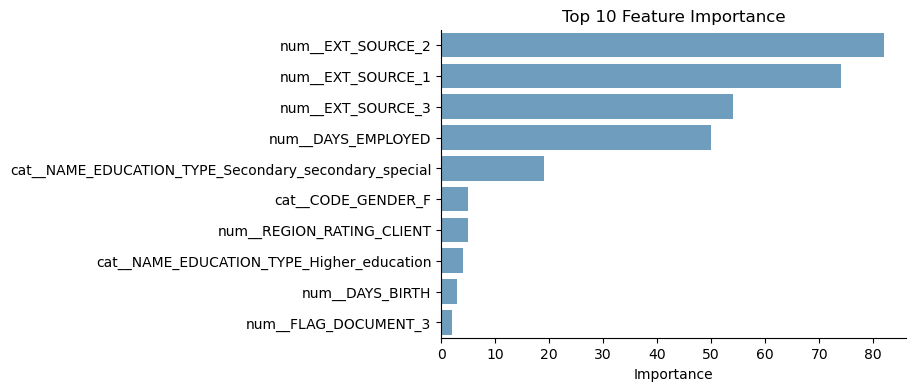

In [12]:
best_lgbm_model1 = randomized_search1.best_estimator_
model_select.plot_feature_importance(best_lgbm_model1, X_train_ready, y_train)

As we can see, the model finds as most important features the **External sources (2, 1 and 3)** of information about the clients. Our **f1-score for this model is 0.2474**.

<h2 style="color:#774CAD">New Features</h2>

In this part we will define some new features.

From **EXT_SOURCES** (6 new features):
- products,
- sum,
- mean,
- products each 2 features (EX1 x EX2,...).

From the **AMT_ features** (14 new features):
- ratio between some of the AMT_ features and themselves.
- ratio between some of the AMT_ features and 'DAYS_BIRTH', 'DAYS_EMPLOYED'.

Also:
- age, 
- age bins, 
- years of work,
- percent of worked days

In [13]:
num_feats[0:8]

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED'],
      dtype='object')

In [14]:
feat_eng_pipe2 = Pipeline(
    steps=[
        ("drop_mode_avg", feat_eng.DropModeAVG()),
        ('zero_null_transformer', feat_eng.ZeroToNullTransformer(columns="YEARS_BEGINEXPLUATATION_MEDI")),
        ('multiply_by_neg1', feat_eng.MultiplyByNeg1(columns=[col for col in df_train.columns if col.startswith('DAYS_')])),
        ('days_empl_anomaly', feat_eng.HandleDaysEmployedAnomaly()),
        ('map_loan_titles', feat_eng.ApplyMapToOrganization(column="ORGANIZATION_TYPE", similarity_threshold=70)),
        ('ext_sources_transformer', feat_eng.ExternalSourcesTransformer()),
        ('financial_ratio_transformer', feat_eng.FinancialRatioTransformer()),
        ('age_employment_transformer', feat_eng.AgeAndEmploymentTransformer()),
    ]
)

In [15]:
X_train_FE = feat_eng_pipe2.fit_transform(X_train)
num_feats, cat_feats, binary_feats, highcard_feats = utils.extract_features(X_train_FE)

In [16]:
preprocess_pipe = pipelines.create_preprocess_pipeline(num_feats, binary_feats, highcard_feats)
preprocess_pipe

X_train_ready = preprocess_pipe.fit_transform(X_train_FE)
X_train_ready = X_train_ready.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
print(X_train_ready.shape, y_train.size)
X_train_ready.head(3)

(153755, 178) 153755


,num__CNT_CHILDREN,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__DAYS_ID_PUBLISH,...,cat__ORGANIZATION_TYPE_Grouped_Industry_type,cat__ORGANIZATION_TYPE_Grouped_Kindergarten,cat__ORGANIZATION_TYPE_Grouped_Medicine,cat__ORGANIZATION_TYPE_Grouped_Other,cat__ORGANIZATION_TYPE_Grouped_Rare,cat__ORGANIZATION_TYPE_Grouped_School,cat__ORGANIZATION_TYPE_Grouped_Self_employed,cat__ORGANIZATION_TYPE_Grouped_Trade_type,cat__ORGANIZATION_TYPE_Grouped_Transport_type,cat__ORGANIZATION_TYPE_Grouped_XNA
0,0.000,-1.150,-0.618,-0.878,-0.612,-0.034,0.969,NaN,0.605,0.728,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.100,1.246,0.545,1.082,1.467,-0.012,NaN,0.522,-0.940,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,1.000,-0.400,1.918,0.885,2.041,-0.003,0.368,NaN,0.036,0.782,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<h3 style="color:#774CAD">Applying to Model</h3>

In [17]:
randomized_search2 = randomized_search_LGBM(X_train_ready, y_train)
randomized_search2 = randomized_search2.fit(X_train_ready, y_train)
randomized_search2

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            learning_rate=0.01, n_estimators=10,
                                            random_state=1, verbose=-1),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001645BE18310>},
                   random_state=1, scoring=make_scorer(f1_score, pos_label=1))

In [18]:
lgbm_results2 = {
    'model': randomized_search2.best_estimator_,
    'best_params': randomized_search2.best_params_,
    'best_score': randomized_search2.best_score_
}

lgbm_results2

{'model': LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=6,
                n_estimators=10, random_state=1, verbose=-1),
 'best_params': {'max_depth': 6},
 'best_score': 0.24911219410585855}

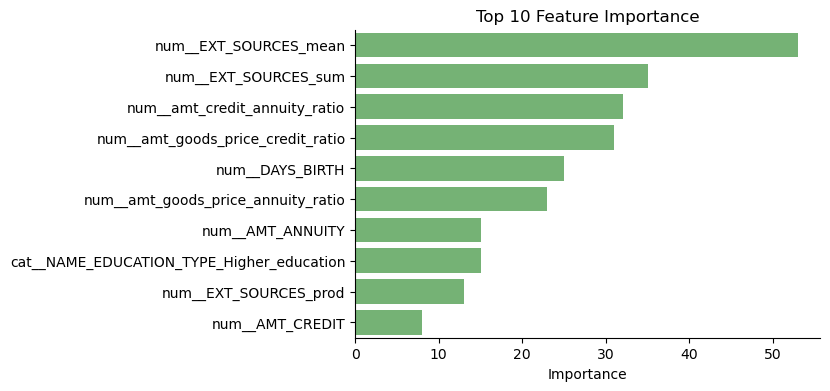

In [19]:
best_lgbm_model2 = randomized_search2.best_estimator_
model_select.plot_feature_importance(best_lgbm_model2, X_train_ready, y_train, color='tab:green')

The **f1-score** for our best model improved from 0.2474 to **0.2491**. We can see that many of the **recently engineered features belong to the top 10** most important, with the mean and sum of the EXT_sources being the most important. In order to improve this results, it is clear that we need to explore and further analyse some of the other dataframes.

We will start with the previous applications and installments.